# Algoritma Genetika
## Penjelasan, ini nanti dimasukan ke bab 4

Datasheet yang digunakan sebelumnya hasih pembersihan oleh Andi Hoerudin dalam penelitiannya yang berjudul “judul punya andi” belum dibersihkan dan masih terdapat kolom yang kosong, data dalam format csv dibersihkan menggunakan package pandas, 

beberapa package library diperlukan untuk menjalankan program algoritma genetika, untuk implementasinya digunakan bahasa pemrograman python dan jupyter notebook untuk penulisan kode program dan VSCODE sebagai IDE.


### Pemanggilan library yang digunakan


In [2]:
import pandas as pd
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import numpy as np
import random
import pickle as pkl
import matplotlib.pyplot as plt

### Pemanggilan Datasheet

In [3]:
umkm = pd.read_csv('umkm2.csv')
umkm.head()

,IDPerusahaan,Nama,R109,Prov,R203D,R204A,R205,R302,R303A,R311C,...,R306,R318,R307,R403,R311,R308,R309,R317,R401L7,LABEL
0,1500755641,MESTA UD JUAL PULSA,1.0,1,4,6,1,1,1,1,...,2,2,2,1,2,2,2,4,2,-1
1,1500755686,PENJUAL PULSA<FEBERWATI>,1.0,1,7,8,2,1,2,1,...,9,2,2,3,4,3,1,4,2,1
2,1500755687,PENJUAL PULSA<HOTNA>,1.0,1,3,8,2,1,2,3,...,2,2,1,4,3,2,1,4,2,-1
3,1500755758,JUAL PULSA<SOKHI>,1.0,1,4,8,2,1,2,2,...,8,2,2,3,3,4,2,4,2,1
4,1500755780,PENJUAL PULSA HP <FATI>,1.0,1,3,8,2,1,2,1,...,1,2,2,1,4,2,1,4,2,-1


### Membersihkan Data Dimana masih terdapat field yang berisi text dan field yang memiliki nilai null
dalam proses ini juga dilakukan perubahan nama kolom label menjadi class dan merubah nilai -1 pada class menjadi 0

In [4]:
umkm = umkm.drop(['IDPerusahaan','Nama','R109'], axis = 1)
umkm.columns = ['Prov','R203D','R204A','R205','R302','R303A','R311C','R408','R306','R318','R307','R403','R311','R308','R309','R317','R401L7','class']
umkm['class']=umkm['class'].map({1:1,-1:0})
umkm.head()

,Prov,R203D,R204A,R205,R302,R303A,R311C,R408,R306,R318,R307,R403,R311,R308,R309,R317,R401L7,class
0,1,4,6,1,1,1,1,1,2,2,2,1,2,2,2,4,2,0
1,1,7,8,2,1,2,1,6,9,2,2,3,4,3,1,4,2,1
2,1,3,8,2,1,2,3,3,2,2,1,4,3,2,1,4,2,0
3,1,4,8,2,1,2,2,3,8,2,2,3,3,4,2,4,2,1
4,1,3,8,2,1,2,1,3,1,2,2,1,4,2,1,4,2,0


### Memastikan jika benar sudah tidak ada kolom dengan data yang kosong

In [5]:
pd.isnull(umkm).any()

Prov      False
R203D     False
R204A     False
R205      False
R302      False
R303A     False
R311C     False
R408      False
R306      False
R318      False
R307      False
R403      False
R311      False
R308      False
R309      False
R317      False
R401L7    False
class     False
dtype: bool

### Membagi datasheet
80 % untuk kebutuhan data latih dan 20% untuk kebutuhan data uji

In [6]:
y_train = umkm['class']
x_train = umkm.drop(labels =['class'],axis=1)

ohe = OneHotEncoder()
le = LabelEncoder()

cols = x_train.columns.values
for col in cols:
    x_train[col] = le.fit_transform(x_train[col])

y_train = le.fit_transform(y_train)

ohe = OneHotEncoder(categories='auto')
x_train = ohe.fit_transform(x_train).toarray()
sc = StandardScaler()
x_train = sc.fit_transform(x_train)


x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size = 0.80,random_state = 42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test,y_test, test_size = 0.20,
random_state = 42)

### Artificial Neural Network
<img src="ann.png">

ANN dilakuka untuk mencari nilai akurasi, prediksi dan fitness

In [8]:
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def relu(x):
    return np.maximum(0, x)

def forward(x, w, activation):
    return activation(np.matmul(x, w))

def accuracy_fn(y, y_hat):
    return (np.where(y == y_hat)[0].size / y_hat.size)

def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))
    
    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        predictions[idx] = np.where(r1 == np.max(r1))[0][0]

    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions
    
def fitness(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

### Vector-Matrix Manipulations

In [9]:
def mat_to_vector(mat_pop_weights):
    weights_vector = []
    for idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[idx, layer_idx], newshape=(mat_pop_weights[idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)


def vector_to_mat(vector_weights, mat_pop_weights):
    mat_weights = []
    for idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[idx, layer_idx].size
            curr_vector = vector_weights[idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

## Algoritma Genetik
<img src="ag.png">

Berikut merupakan proses dari Algoritma Genetika

In [10]:
def mating_pool(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99
    return parents


def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint32(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        
    return offspring

def mutation(offspring_crossover, mutation_percent):
    num_mutations = np.uint32((mutation_percent*offspring_crossover.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
    
    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    
    return offspring_crossover

## Menentukan Parameter

In [11]:
solution_per_population = 8
num_parents_mating = 4
num_generations = 100
mutation_percent = 0.20

### Input dan Output

In [12]:
input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

## Initial weights
menambahkan nilai weight

In [13]:
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):
    
    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1,size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

### memanggil kembali Vector-Matrix Manipulations dan weight

In [15]:
weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

## Training Data
Kode berikut merupakan proses untuk melakukan training data berdasarkan parameter yang sudah ditentukan sebelumnya

In [16]:
for generation in tqdm(range(num_generations)):

    # vector ke matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness dari population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)
    
    # menetapkan nilai fitness pertama ke dalam array
    accuracies[generation] = fit[0]

    # memilih perkawinan parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # menghasilkan populasi baru menggunakan persilangan (crossover)
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # menambahkan mutation kedalam population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)
    
    # populasi baru yang menggabungkan parents dari crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation

100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


## Analisa Data Training
dari hasil proses iterasi di atas menunjukan waktu pemrosesan untuk 100 kali iterasi adalah 3 menit 

In [20]:
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
print("Akurasi dari solusi terbaik adalah : ", acc)

Akurasi dari solusi terbaik adalah :  0.7382893988241988


## Menampilkan hasil analisa data training ke dalam plot
hasil diatas menunjukan nilai akurasi 73% dari 100 kali jumlah generation / iterasi

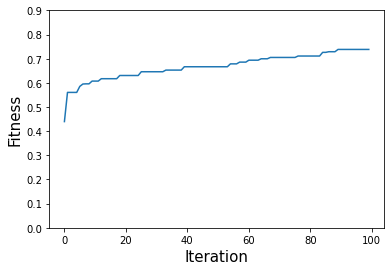

In [18]:
plt.plot(accuracies)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.xticks(np.arange(0, num_generations+1, 20))
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

## Uji Coba mendapatkan nilai Prediksi

In [21]:
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_test, y_test, best_weights, sigmoid)
print("Akurasi dari solusi terbaik adalah : ", acc)

Akurasi dari solusi terbaik adalah :  0.7433041004977483


## Hasil dan Kesimpulan
didapatkan nilai akurasi dari solusi terbaik adalah 74% 
hasil berikut mengalami kenaikan berdasarkan nilai data training sebelumnya